In [3]:
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.stats import zscore
import numpy as np

## Read in data
Seperating the attributes from the result

In [4]:
file = pd.read_csv("heart_data.txt")

cols = ['sbp', 'tobacco', 'ldl', 'adiposity', 'typea', 'obesity', 'alcohol', 'age']
data = pd.DataFrame([file[col] for col in cols]).T
famhist = [1 if val == 'Present' else 0 for val in file['famhist']]
data['famhist'] = famhist
data = pd.DataFrame(zscore(data, ddof=1))
cols.append('famhist')
data.columns = cols

data

,sbp,tobacco,ldl,adiposity,typea,obesity,alcohol,age,famhist
0,1.057417,1.821099,0.477894,-0.295183,-0.418017,-0.176594,3.274189,0.628654,1.184570
1,0.276789,-0.789382,-0.159507,0.411694,0.193134,0.670646,-0.612081,1.381617,-0.842361
2,-0.991731,-0.774141,-0.608585,0.883374,-0.112441,0.734723,-0.540597,0.217947,1.184570
3,1.545310,0.841352,0.806252,1.622382,-0.214300,1.411091,0.294742,1.039361,1.184570
4,-0.211103,2.169453,-0.598928,0.305020,0.702427,-0.012842,1.645991,0.423301,1.184570
...,...,...,...,...,...,...,...,...,...
457,3.692037,-0.704470,0.598614,0.811401,1.109862,0.570971,-0.696228,1.039361,-0.842361
458,2.130781,0.122871,-0.159507,0.860240,-0.112441,0.608942,0.068445,0.628654,-0.842361
459,-1.479624,-0.138395,-1.521228,-1.307946,-1.334744,-1.413043,0.391960,0.834008,-0.842361
460,-0.991731,0.384137,3.317227,0.691875,1.109862,0.309916,0.282897,-0.192760,-0.842361


## Define test and train data
Getting the test and train data values based on a simple slice (k-fold could be used here)

Data is mapped as torch tensors with floats

In [5]:
train_size = 0.9
split_idx = int(len(data) * train_size)
x_train, x_test = map(torch.tensor, ((data.iloc[:split_idx].values), (data.iloc[split_idx:].values)))
y_train, y_test = map(torch.tensor, ((file['chd'][:split_idx].values), (file['chd'][split_idx:].values)))
x_train, x_test, y_train, y_test = x_train.float(), x_test.float(), y_train.float(), y_test.float()

In [34]:
n_input, n_hidden, n_out, learning_rate = 9, 12, 1, 0.1

model = nn.Sequential(nn.Linear(n_input, n_hidden),
                      nn.ReLU(),
                      nn.Linear(n_hidden, n_out),
                      nn.Sigmoid())

print("ANN model, this could be changed to other values")
print(model)

loss_function = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

ANN model, this could be changed to other values
Sequential(
  (0): Linear(in_features=9, out_features=12, bias=True)
  (1): ReLU()
  (2): Linear(in_features=12, out_features=1, bias=True)
  (3): Sigmoid()
)


## NN loop
This is the actual loop running the machine learning model

In [31]:
train_loss, test_loss = [], []
for epoch in range(20000):
    pred_y = model(x_train)
    loss = loss_function(pred_y.flatten(), y_train)
    train_loss.append(loss.item())

    pred_y_test = model(x_test)
    loss_test = loss_function(pred_y_test.flatten(), y_test)
    test_loss.append(loss_test.item())
    
    model.zero_grad()
    loss.backward()

    optimizer.step()

## Loss plots

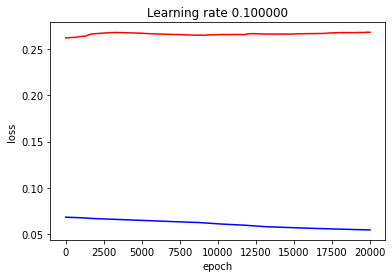

In [33]:
plt.plot(train_loss, 'b')
plt.plot(test_loss, 'r')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title("Learning rate %f"%(learning_rate))
plt.show()

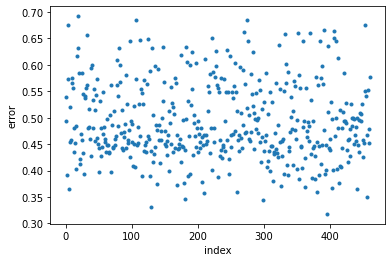

In [37]:
errs = [abs(float(model(torch.tensor(data.iloc[idx].values).float()) - file['chd'][idx])) for idx in range(len(data))]
plt.plot(errs, '.')
plt.ylabel("error")
plt.xlabel("index")
plt.show()